In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")


In [ ]:
file_path = r"C:\Users\manju\OneDrive\Desktop\Documents\Data Analytics\DA Semester 3\Capstone Project 1\Hospital Provider Cost Report\Complete\combined_hospital_cost_reports_2011_2022.csv"
df_raw = pd.read_csv(file_path, low_memory=False)

print(f"Original shape: {df_raw.shape}")
print("Preview:")
df_raw.head()

Original shape: (73974, 118)
Preview:


,Inventory,Provider Type,rpt_rec_num,Type of Control,Less Total Operating Expense,Accounts Receivable,Stand-Alone CHIP Charges,Prepaid Expenses,CCN Facility Type,Notes and Loans Payable (Short Term),...,Total Salaries From Worksheet A,Overhead Non-Salary Costs,Fixed Equipment,Total Days (V + XVIII + XIX + Unknown),Total Unreimbursed and Uncompensated Care,Total Assets,Medicare CBSA Number,Other Current Assets,Major Movable Equipment,FTE - Employees on Payroll
0,564530.0,1,285,9,71334753.0,6379506.0,NaN,190283.0,STH,NaN,...,26663251.0,44671502.0,6317632.0,19641.0,1439490.0,109224801.0,13820.0,1298182.0,49309588.0,598.72
1,174550.0,1,1022,2,10224482.0,2832699.0,NaN,66852.0,CAH,133727.0,...,3378929.0,6845553.0,NaN,1196.0,827330.0,23319725.0,99927.0,NaN,4178909.0,70.56
2,189453.0,1,1496,5,13288563.0,4915619.0,NaN,10221.0,STH,NaN,...,5244796.0,8043763.0,NaN,2681.0,1911488.0,3634507.0,99919.0,NaN,2609020.0,72.65
3,134049.0,5,1501,4,28191835.0,4851517.0,NaN,104878.0,RH,NaN,...,14845640.0,13346195.0,NaN,32378.0,-8796.0,83044000.0,13820.0,NaN,2425479.0,297.77
4,122400.0,5,1504,4,15733902.0,1969952.0,NaN,86945.0,RH,NaN,...,8290506.0,7443396.0,NaN,16961.0,-14956.0,49107070.0,45300.0,NaN,3463806.0,154.60


In [ ]:
df = df_raw.copy()
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(r"\s+", "_", regex=True)
    .str.replace(r"[^a-z0-9_]+", "_", regex=True)
)

In [ ]:
placeholders = {
    "", ".", "..", "...", "na", "n/a", "n-a", "n_a",
    "none", "null", "not_available", "missing", "invalid",
    "error", "nan", "nan.", "#value!", "#div/0!"
}

def normalize_placeholders(x):
    if isinstance(x, str) and x.strip().lower() in placeholders:
        return np.nan
    return x

df = df.applymap(normalize_placeholders)

print("\n Placeholders standardized to NaN")

C:\Users\manju\AppData\Local\Temp\ipykernel_14812\785972585.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(normalize_placeholders)



 Placeholders standardized to NaN


In [ ]:
# Step 4. Convert Numeric Columns Safely

def try_numeric(series):
    """
    Converts a pandas Series to numeric if at least 80% of non-missing values
    can be parsed as numbers. Otherwise leaves it as text.
    """
    # Remove formatting that breaks numeric conversion
    s = (
        series.astype(str)
        .str.replace(",", "", regex=False)
        .str.replace("$", "", regex=False)
        .str.replace(" ", "", regex=False)
        .str.replace("\u00a0", "", regex=False)  # non-breaking space
    )
    # Replace placeholder strings with NaN
    s = s.mask(s.str.lower().isin(placeholders))
    converted = pd.to_numeric(s, errors="coerce")

    # Heuristic: if ≥80 % numeric-like, keep as numeric
    ratio = converted.notna().sum() / max(1, s.notna().sum())
    if ratio >= 0.8:
        return converted
    else:
        return series  # keep as original text

# Apply conversion to all columns
for col in df.columns:
    df[col] = try_numeric(df[col])

print("\n Numeric columns converted where appropriate")

# Optional check: view a few numeric columns
print(df.select_dtypes(include=["number"]).head())


 Numeric columns converted where appropriate
   inventory  provider_type  rpt_rec_num  type_of_control  \
0   564530.0              1          285                9   
1   174550.0              1         1022                2   
2   189453.0              1         1496                5   
3   134049.0              5         1501                4   
4   122400.0              5         1504                4   

   less_total_operating_expense  accounts_receivable  \
0                    71334753.0            6379506.0   
1                    10224482.0            2832699.0   
2                    13288563.0            4915619.0   
3                    28191835.0            4851517.0   
4                    15733902.0            1969952.0   

   stand_alone_chip_charges  prepaid_expenses  \
0                       NaN          190283.0   
1                       NaN           66852.0   
2                       NaN           10221.0   
3                       NaN          104878.0   
4    

In [ ]:
# Step 6. Clean Identifiers & Drop Duplicates

# Ensure provider_ccn exists and is clean
if "provider_ccn" in df.columns:
    df["provider_ccn"] = (
        df["provider_ccn"]
        .astype(str)
        .str.replace(r"\.0$", "", regex=True)
        .str.replace(r"\D", "", regex=True)
        .str.zfill(6)  # always 6 digits
    )

# Remove duplicate report records
if "rpt_rec_num" in df.columns:
    before = len(df)
    df = df.drop_duplicates(subset="rpt_rec_num", keep="first")
    print(f"Duplicates removed: {before - len(df)} based on 'rpt_rec_num'")
else:
    # Fallback: drop fully identical rows
    before = len(df)
    df = df.drop_duplicates()
    print(f"Duplicates removed: {before - len(df)} identical rows")

# Optional check: duplicates by provider & fiscal year (if available)
if {"provider_ccn", "fiscal_year_end_date"} <= set(df.columns):
    dup_check = df[df.duplicated(subset=["provider_ccn", "fiscal_year_end_date"], keep=False)]
    print(f"Potential duplicate years per provider: {dup_check.shape[0]}")

Duplicates removed: 0 based on 'rpt_rec_num'
Potential duplicate years per provider: 0


In [ ]:
# Step 7. Parse Date Columns
# Convert any column name containing "date" to datetime
for col in df.columns:
    if "date" in col.lower():
        df[col] = pd.to_datetime(df[col], errors="coerce")

print("Date columns converted to datetime format.")

# Optional: quickly inspect the parsed date columns
date_cols = [c for c in df.columns if "date" in c.lower()]
print(f"Parsed {len(date_cols)} date columns:")
print(date_cols)
print(df[date_cols].head())

Date columns converted to datetime format.
Parsed 2 date columns:
['fiscal_year_begin_date', 'fiscal_year_end_date']
  fiscal_year_begin_date fiscal_year_end_date
0             2010-10-01           2011-09-30
1             2011-01-01           2011-12-31
2             2011-01-01           2011-12-31
3             2011-01-01           2011-12-31
4             2011-01-01           2011-12-31


In [ ]:
# Step 7b️ Validate Fiscal Year Dates
if {"fiscal_year_begin_date", "fiscal_year_end_date"} <= set(df.columns):
    df["fiscal_year_length_days"] = (
        df["fiscal_year_end_date"] - df["fiscal_year_begin_date"]
    ).dt.days

    invalid_order = (df["fiscal_year_length_days"] < 0).sum()
    avg_length = df["fiscal_year_length_days"].mean().round(1)
    print(f"Average fiscal year length: {avg_length} days")
    print(f"{invalid_order} rows where end_date < begin_date")

    print(df[["fiscal_year_begin_date", "fiscal_year_end_date", "fiscal_year_length_days"]].head())


Average fiscal year length: 357.3 days
0 rows where end_date < begin_date
  fiscal_year_begin_date fiscal_year_end_date  fiscal_year_length_days
0             2010-10-01           2011-09-30                      364
1             2011-01-01           2011-12-31                      364
2             2011-01-01           2011-12-31                      364
3             2011-01-01           2011-12-31                      364
4             2011-01-01           2011-12-31                      364


In [ ]:
# Step 7c Extract Fiscal Year for Analysis
df["fiscal_year"] = df["fiscal_year_end_date"].dt.year
print(" Fiscal year extracted from end date.")
print(df[["fiscal_year_begin_date", "fiscal_year_end_date", "fiscal_year"]].head())

 Fiscal year extracted from end date.
  fiscal_year_begin_date fiscal_year_end_date  fiscal_year
0             2010-10-01           2011-09-30         2011
1             2011-01-01           2011-12-31         2011
2             2011-01-01           2011-12-31         2011
3             2011-01-01           2011-12-31         2011
4             2011-01-01           2011-12-31         2011


In [ ]:
# Step 8. Compute Derived Metrics Safely

def safe_ratio(num, den):
    """Avoid division by zero or NaN issues."""
    return np.where((den.notna()) & (den != 0), num / den, np.nan)

# Initialize a list to store created metric names
created_metrics = []

#  Occupancy Rate
for days_col in ["total_days__v___xviii___xix___unknown_", "total_days_v_xviii_xix_unknown"]:
    for beds_col in ["total_bed_days_available", "total_bed_days_available_for_all_subproviders"]:
        if days_col in df.columns and beds_col in df.columns:
            df["occupancy_rate"] = safe_ratio(df[days_col], df[beds_col])
            created_metrics.append("occupancy_rate")

# Cost-to-Charge Ratio (CCR)
for cost_col in ["total_costs", "total_operating_expenses"]:
    for charge_col in [
        "combined_outpatient_+_inpatient_total_charges",
        "combined_outpatient___inpatient_total_charges",
        "inpatient_total_charges",
        "total_charges",
    ]:
        if cost_col in df.columns and charge_col in df.columns:
            df["cost_to_charge_ratio_calc"] = safe_ratio(df[cost_col], df[charge_col])
            created_metrics.append("cost_to_charge_ratio_calc")

# Profit Margin
for ni_col in ["net_income", "total_net_income"]:
    for rev_col in ["total_patient_revenue", "net_patient_revenue", "total_revenue"]:
        if ni_col in df.columns and rev_col in df.columns:
            df["profit_margin_calc"] = safe_ratio(df[ni_col], df[rev_col])
            created_metrics.append("profit_margin_calc")

# Charity Care Ratio
for charity_col in ["cost_of_charity_care", "uncompensated_care_cost"]:
    if charity_col in df.columns and "total_costs" in df.columns:
        df["charity_care_ratio"] = safe_ratio(df[charity_col], df["total_costs"])
        created_metrics.append("charity_care_ratio")

print(f"Derived metrics added: {created_metrics if created_metrics else 'None (columns not found)'}")

# Step 8b Summary of Derived Metrics
metric_cols = [c for c in ["occupancy_rate", "cost_to_charge_ratio_calc", "profit_margin_calc", "charity_care_ratio"] if c in df.columns]

for col in metric_cols:
    print(f"\n Summary of {col}:")
    print(df[col].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95]).round(4))

# Optional preview of metrics (only columns that exist)
preview_cols = [c for c in ["provider_ccn", "fiscal_year"] + metric_cols if c in df.columns]
print("\n Sample rows with derived metrics:")
display(df[preview_cols].head())

Derived metrics added: ['occupancy_rate', 'cost_to_charge_ratio_calc', 'cost_to_charge_ratio_calc', 'profit_margin_calc', 'profit_margin_calc', 'charity_care_ratio']

 Summary of occupancy_rate:
count    72886.0000
mean         0.5245
std          3.4372
min          0.0000
25%          0.3191
50%          0.5192
75%          0.6959
90%          0.8207
95%          0.8839
max        922.0000
Name: occupancy_rate, dtype: float64

 Summary of cost_to_charge_ratio_calc:
count    7.295700e+04
mean     4.488321e+02
std      6.983123e+04
min      0.000000e+00
25%      4.089000e-01
50%      7.155000e-01
75%      1.619400e+00
90%      3.210700e+00
95%      5.114400e+00
max      1.621224e+07
Name: cost_to_charge_ratio_calc, dtype: float64

 Summary of profit_margin_calc:
count    7.089600e+04
mean    -3.130274e+03
std      6.565190e+05
min     -1.589017e+08
25%     -2.160000e-02
50%      4.620000e-02
75%      1.225000e-01
90%      2.190000e-01
95%      2.934000e-01
max      3.201284e+07
Name: p

,provider_ccn,fiscal_year,occupancy_rate,cost_to_charge_ratio_calc,profit_margin_calc,charity_care_ratio
0,010005,2011,0.472026,0.844850,-0.042515,0.022639
1,271326,2011,0.131068,3.881714,-0.096679,0.023203
2,010052,2011,0.159678,2.660672,0.010086,NaN
3,013025,2011,0.887068,0.467989,0.297379,NaN
4,103037,2011,0.663836,0.663339,0.225524,NaN


In [ ]:
# Step 9. Validation & Outlier Checks

validation_results = {}

# Occupancy rate checks
if "occupancy_rate" in df.columns:
    invalid_occ = df[df["occupancy_rate"] > 1.2]
    neg_occ = df[df["occupancy_rate"] < 0]
    validation_results["invalid_occupancy"] = invalid_occ.shape[0]
    validation_results["negative_occupancy"] = neg_occ.shape[0]
    print(f"Occupancy >120%: {invalid_occ.shape[0]} | Negative occupancy: {neg_occ.shape[0]}")

# CCR checks
if "cost_to_charge_ratio_calc" in df.columns:
    invalid_ccr = df[df["cost_to_charge_ratio_calc"] > 5]
    validation_results["invalid_ccr"] = invalid_ccr.shape[0]
    print(f"CCR > 5 (unusually high): {invalid_ccr.shape[0]}")

# Profit margin checks
if "profit_margin_calc" in df.columns:
    neg_margin = (df["profit_margin_calc"] < -1).sum()
    high_margin = (df["profit_margin_calc"] > 1).sum()
    validation_results["negative_profit_margin"] = int(neg_margin)
    validation_results["extreme_profit_margin"] = int(high_margin)
    print(f"Extreme profit margins (<-100% or >100%): {neg_margin + high_margin}")

# Charity care ratio checks
if "charity_care_ratio" in df.columns:
    extreme_charity = df[df["charity_care_ratio"] > 2]
    validation_results["extreme_charity_care_ratio"] = extreme_charity.shape[0]
    print(f"Charity care ratio > 2: {extreme_charity.shape[0]}")

# Summary
print("\n Validation summary:")
for k, v in validation_results.items():
    print(f" - {k}: {v}")

# Optional: show sample anomalies for inspection
print("\n Sample of extreme occupancy or CCR values:")
cols_to_show = ["provider_ccn", "fiscal_year", "occupancy_rate", "cost_to_charge_ratio_calc"]
display(df.loc[(df["occupancy_rate"] > 1.2) | (df["cost_to_charge_ratio_calc"] > 5), cols_to_show].head(10))

Occupancy >120%: 60 | Negative occupancy: 0
CCR > 5 (unusually high): 3753
Extreme profit margins (<-100% or >100%): 905
Charity care ratio > 2: 5

 Validation summary:
 - invalid_occupancy: 60
 - negative_occupancy: 0
 - invalid_ccr: 3753
 - negative_profit_margin: 654
 - extreme_profit_margin: 251
 - extreme_charity_care_ratio: 5

 Sample of extreme occupancy or CCR values:


,provider_ccn,fiscal_year,occupancy_rate,cost_to_charge_ratio_calc
143,351310,2012,0.156831,5.060938
146,020027,2011,0.434703,8.046561
147,381310,2012,0.357991,6.269329
191,431310,2012,0.067851,7.335681
205,351309,2012,0.141530,5.224429
246,014011,2011,0.983676,100.091398
273,244015,2011,0.817613,206.662422
293,014012,2011,0.998226,214.261155
325,102000,2012,0.358715,5.525399
327,271300,2012,0.410929,6.928390


In [ ]:
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("coolwarm")

In [ ]:
# Identify all numeric columns (not just derived)
numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()

print(f"Total numeric columns: {len(numeric_cols)}")
print("Sample of numeric columns:")
print(numeric_cols[:15])  # show first 15


Total numeric columns: 113
Sample of numeric columns:
['inventory', 'provider_type', 'rpt_rec_num', 'type_of_control', 'less_total_operating_expense', 'accounts_receivable', 'stand_alone_chip_charges', 'prepaid_expenses', 'notes_and_loans_payable__short_term_', 'number_of_beds___total_for_all_subproviders', 'number_of_interns_and_residents__fte_', 'total_discharges_title_xviii', 'total_days_title_v', 'land', 'salaries__wages__and_fees_payable']


In [ ]:
# Global Numeric Summary
numeric_cols = df.select_dtypes(include=["number"]).columns

# Describe only true numeric columns
summary = df[numeric_cols].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]).T

# Compute spread measures
summary["iqr"] = summary["75%"] - summary["25%"]
summary["range"] = summary["max"] - summary["min"]

# Ensure all IQR/range are numeric floats
summary = summary.apply(pd.to_numeric, errors="coerce")

# Sort by IQR safely
summary_sorted = summary.sort_values(by="iqr", ascending=False)

print("Top 15 variables with largest spread (IQR):")
print(summary_sorted.head(15)[["mean", "std", "iqr", "range"]])

Top 15 variables with largest spread (IQR):
                                                            mean  \
total_patient_revenue                               6.098842e+08   
combined_outpatient___inpatient_total_charges       5.798122e+08   
less_contractual_allowance_and_discounts_on_pat...  4.490337e+08   
outpatient_revenue                                  3.182356e+08   
outpatient_total_charges                            2.943327e+08   
inpatient_revenue                                   3.197168e+08   
inpatient_total_charges                             3.083037e+08   
total_assets                                        2.443969e+08   
total_liabilities_and_fund_balances                 2.437232e+08   
net_patient_revenue                                 1.665416e+08   
less_total_operating_expense                        1.684635e+08   
total_costs                                         1.357925e+08   
medicaid_charges                                    1.268193e+08   
tota

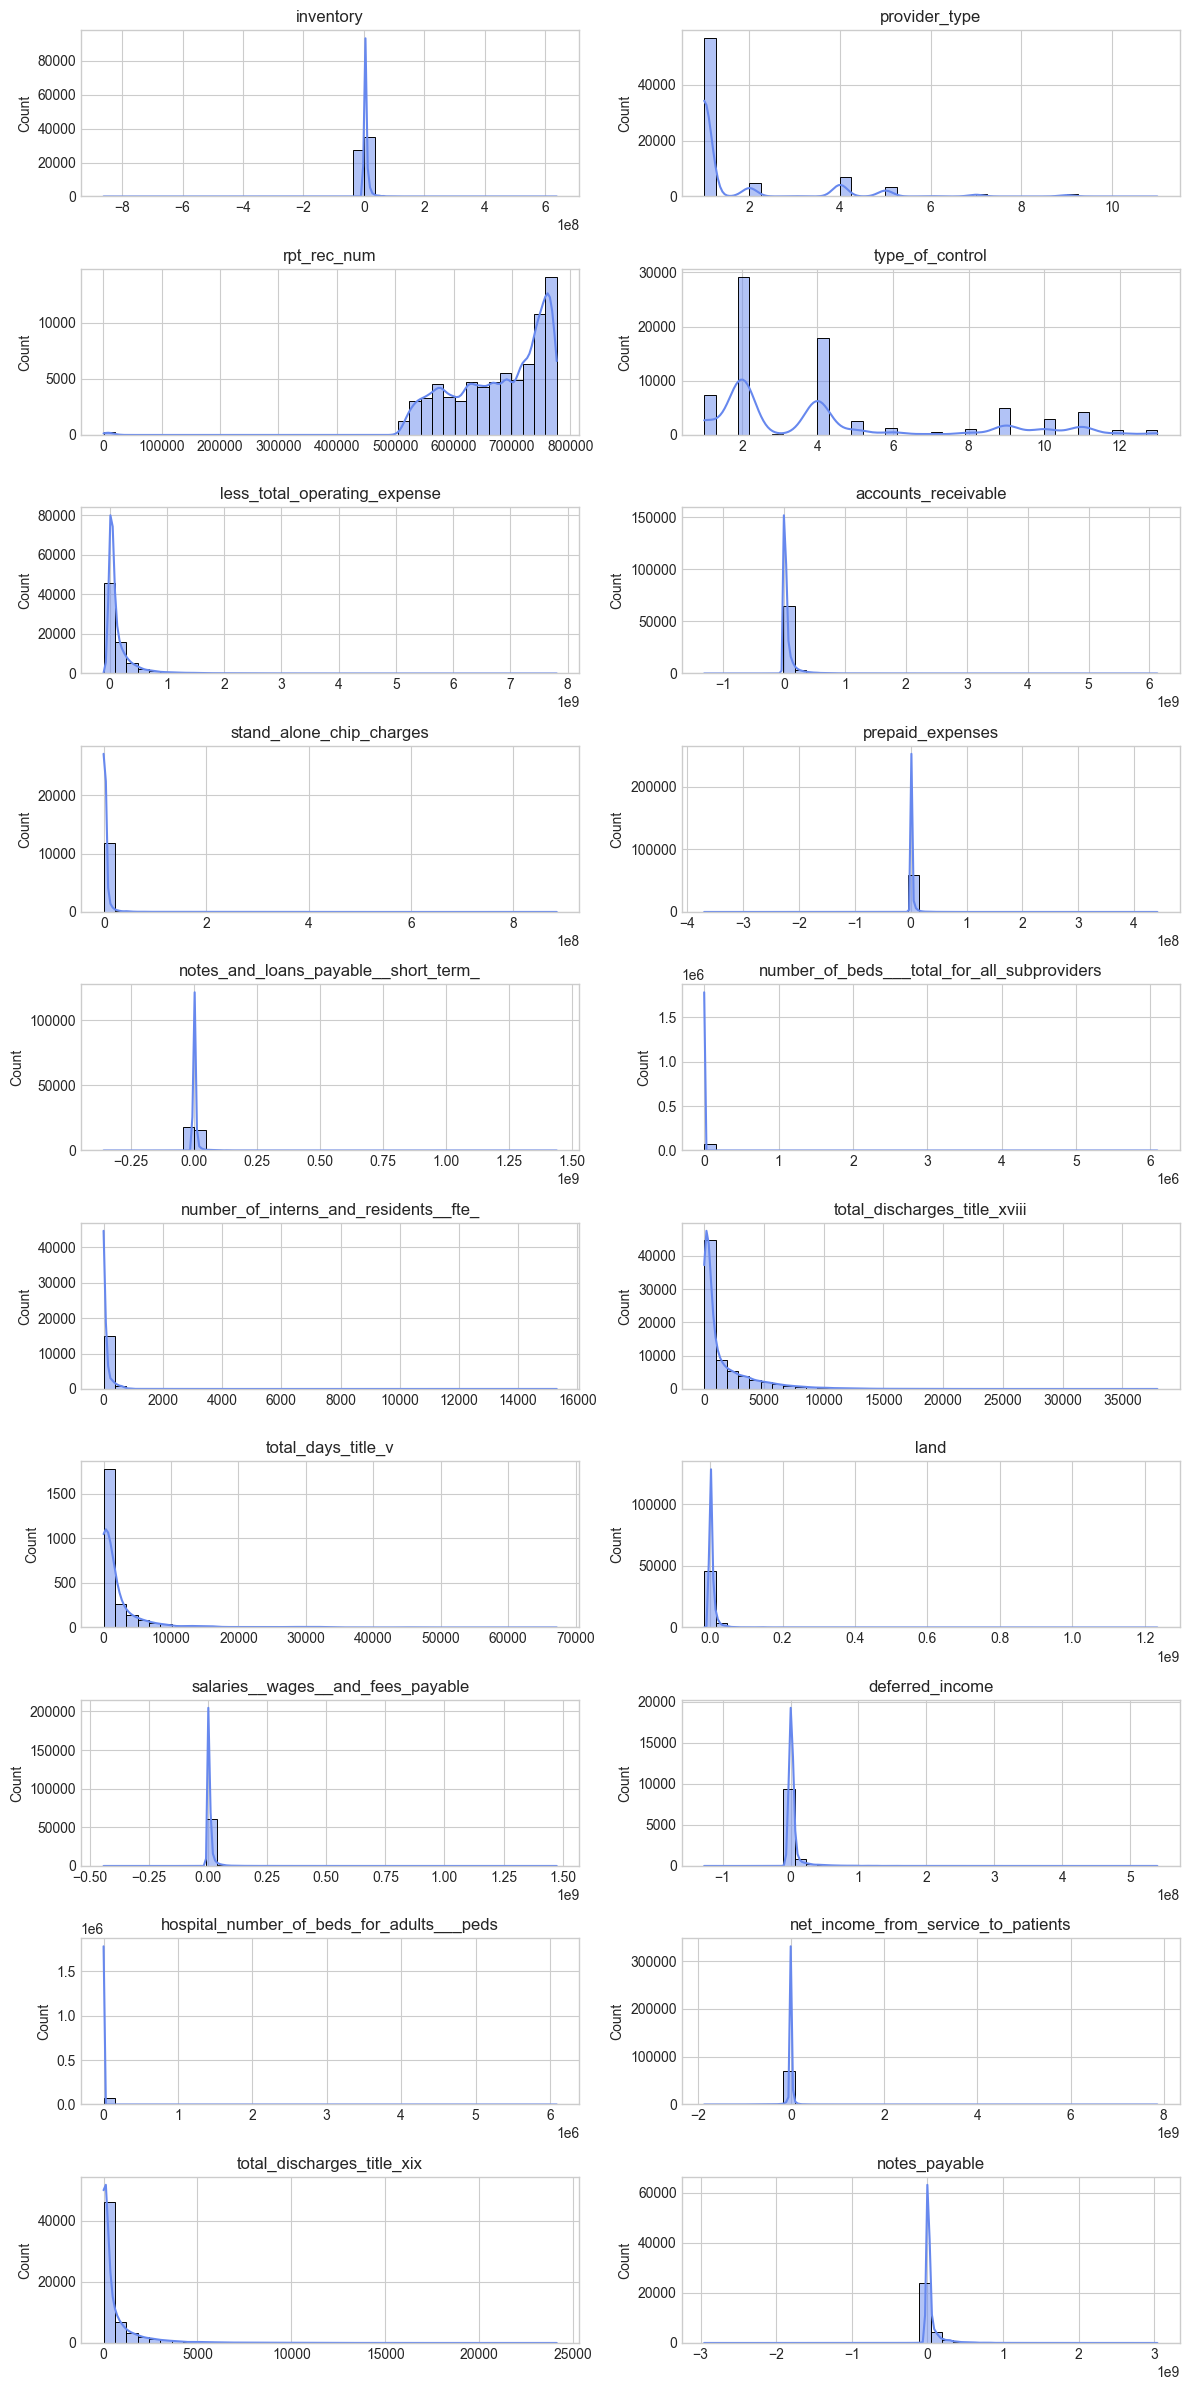

In [ ]:
# Global Numeric Data Distribution Check
plt.style.use("seaborn-v0_8-whitegrid")

# Sample up to 20 numeric columns for plotting
sample_cols = numeric_cols[:20]  # adjust if you want more

fig, axes = plt.subplots(len(sample_cols)//2, 2, figsize=(12, len(sample_cols)*1.2))
axes = axes.flatten()

for i, col in enumerate(sample_cols):
    sns.histplot(df[col], bins=40, kde=True, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel("")
plt.tight_layout()
plt.show()


In [ ]:
# Step: Global Outlier Detection (IQR method)
outlier_counts = {}

for col in df.select_dtypes(include="number").columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    outlier_counts[col] = ((df[col] < lower) | (df[col] > upper)).sum()

outlier_summary = (
    pd.DataFrame.from_dict(outlier_counts, orient="index", columns=["outlier_count"])
    .assign(outlier_rate=lambda x: (x["outlier_count"] / len(df) * 100).round(2))
    .sort_values(by="outlier_rate", ascending=False)
)

print("Top 20 columns with most outliers:")
print(outlier_summary.head(20))


Top 20 columns with most outliers:
                                     outlier_count  outlier_rate
fiscal_year_length_days                      21315         28.81
provider_type                                17411         23.54
net_income_from_service_to_patients          16874         22.81
net_income                                   14631         19.78
total_income                                 14216         19.22
total_liabilities                            10968         14.83
cash_on_hand_and_in_banks                    10085         13.63
total_current_liabilities                    10018         13.54
total_other_income                            9943         13.44
total_long_term_liabilities                   9941         13.44
general_fund_balance                          9665         13.07
total_fund_balances                           9634         13.02
total_other_assets                            9513         12.86
inpatient_total_charges                       9439     

In [ ]:
# Outlier Treatment (Winsorization)

numeric_cols = df.select_dtypes(include=["number"]).columns

# Identify categorical numeric columns that should not be transformed
categorical_like = ["provider_type", "type_of_control"]

# Winsorize all numeric columns (cap at 1st and 99th percentile)
for col in numeric_cols:
    if col not in categorical_like:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = np.clip(df[col], lower, upper)

print("Winsorization applied across all numeric columns (1st–99th percentile caps).")

Winsorization applied across all numeric columns (1st–99th percentile caps).


In [ ]:
# Optionally: Log-transform heavily skewed, positive variables
skewness = df[numeric_cols].skew().sort_values(ascending=False)
right_skewed = skewness[skewness > 1].index.tolist()

for col in right_skewed:
    if (df[col] > 0).all() and col not in categorical_like:
        df[f"log_{col}"] = np.log1p(df[col])

print(f"Log transformation applied to {len(right_skewed)} heavily skewed columns.")

Log transformation applied to 103 heavily skewed columns.


In [ ]:
# Recalculate outlier rates after cleaning
outlier_counts_after = {}

for col in numeric_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    outlier_counts_after[col] = ((df[col] < lower) | (df[col] > upper)).sum()

outlier_summary_after = (
    pd.DataFrame.from_dict(outlier_counts_after, orient="index", columns=["outlier_count_after"])
    .assign(outlier_rate_after=lambda x: (x["outlier_count_after"] / len(df) * 100).round(2))
    .sort_values(by="outlier_rate_after", ascending=False)
)

print("Top 10 columns with most outliers after cleaning:")
print(outlier_summary_after.head(10))


Top 10 columns with most outliers after cleaning:
                                     outlier_count_after  outlier_rate_after
fiscal_year_length_days                            21315               28.81
provider_type                                      17411               23.54
net_income_from_service_to_patients                16874               22.81
net_income                                         14631               19.78
total_income                                       14216               19.22
total_liabilities                                  10968               14.83
total_current_liabilities                          10018               13.54
total_long_term_liabilities                         9941               13.44
total_other_income                                  9576               12.95
inpatient_total_charges                             9439               12.76


In [ ]:
# Step: Manual final tweaks for persistent outliers
# Drop categorical-like variables from numeric checks
exclude_cols = ["provider_type", "type_of_control"]

# Clip fiscal year length to realistic range
if "fiscal_year_length_days" in df.columns:
    df["fiscal_year_length_days"] = df["fiscal_year_length_days"].clip(300, 380)

# Apply log transform to remaining high-outlier columns (if positive)
cols_to_log = [
    "net_income_from_service_to_patients",
    "net_income",
    "total_income",
    "total_liabilities",
    "total_current_liabilities",
    "total_long_term_liabilities",
    "inpatient_total_charges"
]

for col in cols_to_log:
    if col in df.columns and (df[col] > 0).all():
        df[f"log_{col}"] = np.log1p(df[col])

print("Final outlier corrections applied and key variables log-transformed.")


Final outlier corrections applied and key variables log-transformed.


In [ ]:
# Step: Identify categorical columns
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
print(f"Total categorical columns: {len(cat_cols)}")
print(cat_cols)

Total categorical columns: 9
['ccn_facility_type', 'street_address', 'rural_versus_urban', 'state_code', 'city', 'hospital_name', 'zip_code', 'provider_ccn', 'county']


In [ ]:
# Convert encoded numerics to categorical
encoded_cats = ["provider_type", "type_of_control", "rural_versus_urban_code"]
for col in encoded_cats:
    if col in df.columns:
        df[col] = df[col].astype("category")

In [ ]:
# Step: Standardize categorical text values
for col in cat_cols:
    df[col] = df[col].astype(str).str.strip().str.lower()

In [ ]:
# Replace placeholder strings with NaN
placeholders = ["na", "n/a", "none", "missing", "null", "-", "--", " ", "not available"]
df[cat_cols] = df[cat_cols].replace(placeholders, np.nan)

In [ ]:
# Example: make all state codes uppercase and valid
if "state_code" in df.columns:
    df["state_code"] = df["state_code"].str.upper().str.strip()

In [ ]:
# Step: Validate derived metrics
derived_cols = ["occupancy_rate", "cost_to_charge_ratio_calc", "profit_margin_calc", "charity_care_ratio"]

for col in derived_cols:
    if col in df.columns:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)
        df[col] = df[col].clip(lower=-1, upper=5)  # realistic bounds
        df[col] = pd.to_numeric(df[col], errors="coerce")

print("Derived metric validation complete")

Derived metric validation complete


In [ ]:
# Define placeholder strings to replace with NaN
placeholders = ["na", "n/a", "none", "missing", "null", "-", "--", " ", "nan", "not available"]

# Step 1: Trim whitespace and lowercase for all string columns
for col in ['ccn_facility_type', 'street_address', 'rural_versus_urban', 
            'state_code', 'city', 'hospital_name', 'zip_code', 
            'provider_ccn', 'county']:
    
    df[col] = df[col].astype(str).str.strip().str.lower()
    df[col] = df[col].replace(placeholders, np.nan)

# Step 2: Specific column standardizations
if 'state_code' in df.columns:
    df['state_code'] = df['state_code'].str.upper()

if 'zip_code' in df.columns:
    df['zip_code'] = df['zip_code'].str.extract(r'(\d{5})')  # Extract valid 5-digit zip

if 'provider_ccn' in df.columns:
    df['provider_ccn'] = df['provider_ccn'].str.zfill(6)  # Ensure 6-digit format

if 'rural_versus_urban' in df.columns:
    df['rural_versus_urban'] = df['rural_versus_urban'].replace({
        'rural hospital': 'rural', 
        'urban hospital': 'urban', 
        'rural area': 'rural',
        'urban area': 'urban'
    })

# Proper case for city/county/hospital name
for col in ['city', 'county', 'hospital_name']:
    if col in df.columns:
        df[col] = df[col].str.title()

print("Categorical variable cleaning complete!")


Categorical variable cleaning complete!


In [ ]:
# Check for missing values and consistency
print(df[['state_code', 'rural_versus_urban', 'county']].head(10))
print("\nUnique facility types:", df['ccn_facility_type'].unique()[:10])
print("\nNulls in categorical columns:\n", df[['ccn_facility_type', 'state_code', 'rural_versus_urban']].isna().sum())

  state_code rural_versus_urban      county
0         AL                  r    Marshall
1         MT                  r      Carbon
2         AL                  u  Tallapoosa
3         AL                  u   Jefferson
4         FL                  u    Pinellas
5         FL                  u    Hernando
6         IL                  u        Lake
7         IL                  u   Winnebago
8         NJ                  u       Ocean
9         TN                  u    Davidson

Unique facility types: ['sth' 'cah' 'rh' 'rnmhc' 'ph' 'ltch' 'ch' 'ord']

Nulls in categorical columns:
 ccn_facility_type       0
state_code              0
rural_versus_urban    926
dtype: int64


In [ ]:
df["rural_versus_urban"] = df["rural_versus_urban"].fillna("unknown")


In [ ]:
facility_map = {
    "sth": "short-term hospital",
    "cah": "critical access hospital",
    "rh": "rehabilitation hospital",
    "rnmhc": "rehabilitation non-medicare hospital center",
    "ph": "psychiatric hospital",
    "ltch": "long-term care hospital",
    "ch": "children's hospital",
    "ord": "other related department"
}

df["ccn_facility_type_full"] = df["ccn_facility_type"].map(facility_map)
print(df[["ccn_facility_type", "ccn_facility_type_full"]].head(10))

  ccn_facility_type                       ccn_facility_type_full
0               sth                          short-term hospital
1               cah                     critical access hospital
2               sth                          short-term hospital
3                rh                      rehabilitation hospital
4                rh                      rehabilitation hospital
5                rh                      rehabilitation hospital
6             rnmhc  rehabilitation non-medicare hospital center
7                rh                      rehabilitation hospital
8                rh                      rehabilitation hospital
9               sth                          short-term hospital


C:\Users\manju\AppData\Local\Temp\ipykernel_14812\906801453.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["ccn_facility_type_full"] = df["ccn_facility_type"].map(facility_map)


In [ ]:
print("\nCategorical Summary:")
for col in ["ccn_facility_type", "rural_versus_urban", "state_code", "county"]:
    print(f"{col}: {df[col].nunique()} unique values | {df[col].isna().sum()} missing")

print("\nSample cleaned rows:")
print(df[["state_code", "rural_versus_urban", "county", "ccn_facility_type_full"]].head(10))



Categorical Summary:
ccn_facility_type: 8 unique values | 0 missing
rural_versus_urban: 3 unique values | 0 missing
state_code: 56 unique values | 0 missing
county: 1898 unique values | 3822 missing

Sample cleaned rows:
  state_code rural_versus_urban      county  \
0         AL                  r    Marshall   
1         MT                  r      Carbon   
2         AL                  u  Tallapoosa   
3         AL                  u   Jefferson   
4         FL                  u    Pinellas   
5         FL                  u    Hernando   
6         IL                  u        Lake   
7         IL                  u   Winnebago   
8         NJ                  u       Ocean   
9         TN                  u    Davidson   

                        ccn_facility_type_full  
0                          short-term hospital  
1                     critical access hospital  
2                          short-term hospital  
3                      rehabilitation hospital  
4              

In [ ]:
df["county"] = df["county"].fillna("Unknown")

In [ ]:
warnings.filterwarnings("ignore", message=".*partition.*MaskedArray.*")

print("Running Final Data Cleanliness Check...\n")

# 1. Basic Structure
print(f"Dataset shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Column types:\n{df.dtypes.value_counts()}\n")

# 2. Missing Values
missing_summary = df.isna().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
if missing_summary.empty:
    print("No missing values detected in any column.\n")
else:
    print(f"Columns with missing values ({len(missing_summary)}):")
    print(missing_summary.head(10))
    print(f"Total missing entries: {int(missing_summary.sum())}\n")

# 3. Duplicate Checks
duplicate_rows = df.duplicated().sum()
print(f"Duplicate rows: {duplicate_rows}\n")

# 4. Numeric Column Validation
num_cols = df.select_dtypes(include=[np.number]).columns
numeric_issues = {
    "infinite_values": np.isinf(df[num_cols]).any().sum(),
    "negative_values": (df[num_cols] < 0).any().sum(),
    "zero_values": (df[num_cols] == 0).any().sum()
}

print("Numeric Columns Health:")
for k, v in numeric_issues.items():
    print(f"   - {k.replace('_', ' ').capitalize()}: {v} columns affected")

# Detect extreme outliers (beyond 5× IQR)
iqr_outlier_counts = {}
for col in num_cols:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    upper = q3 + 5 * iqr
    lower = q1 - 5 * iqr
    count = df[(df[col] > upper) | (df[col] < lower)].shape[0]
    if count > 0:
        iqr_outlier_counts[col] = count
if iqr_outlier_counts:
    print(f"Extreme numeric outliers detected in {len(iqr_outlier_counts)} columns (beyond 5×IQR).")
else:
    print("No extreme numeric outliers beyond 5×IQR.\n")

# 5. Categorical Validation
cat_cols = df.select_dtypes(include=["object", "category"]).columns
print(f"\n Total categorical columns: {len(cat_cols)}")
for col in cat_cols:
    unique_vals = df[col].nunique()
    print(f"   - {col}: {unique_vals} unique | Missing: {df[col].isna().sum()}")

# 6. Date Integrity
date_cols = [col for col in df.columns if "date" in col]
if date_cols:
    print(f"\nDate columns detected: {date_cols}")
    invalid_dates = df[date_cols].isna().sum().sum()
    if invalid_dates == 0:
        print("All date fields valid.")
    else:
        print(f"{invalid_dates} missing/invalid date entries found.")
else:
    print("\n No date columns detected.\n")

# 7. Overall Summary
total_rows = df.shape[0]
clean_cols = (
    (missing_summary.empty) and
    (duplicate_rows == 0) and
    (numeric_issues["infinite_values"] == 0)
)

if clean_cols:
    print("\n Overall Cleanliness: EXCELLENT — Dataset ready for EDA and modeling.")
else:
    print("\n Some minor issues detected — review warnings above before final export.")

print("\n Data Cleanliness Check Complete.")

Running Final Data Cleanliness Check...

Dataset shape: 73974 rows × 125 columns
Column types:
float64           108
object              8
datetime64[ns]      2
int64               2
category            1
category            1
category            1
category            1
int32               1
Name: count, dtype: int64

Columns with missing values (108):
hospital_total_days_title_v_for_adults___peds          71712
total_discharges_title_v                               71625
hospital_total_discharges_title_v_for_adults___peds    71625
total_days_title_v                                     71531
unsecured_loans                                        70608
notes_receivable                                       70288
wage_related_costs__rhc_fqhc_                          69294
wage_related_costs_for_part___a_teaching_physicians    69170
health_information_technology_designated_assets        67558
drg_amounts_other_than_outlier_payments                66333
dtype: int64
Total missing entries:

In [ ]:
missing_rate = (df.isna().sum() / len(df) * 100).round(2)
missing_high = missing_rate[missing_rate > 50].sort_values(ascending=False)
print("Columns with >50% missing:\n", missing_high.head(10))

Columns with >50% missing:
 hospital_total_days_title_v_for_adults___peds          96.94
total_discharges_title_v                               96.82
hospital_total_discharges_title_v_for_adults___peds    96.82
total_days_title_v                                     96.70
unsecured_loans                                        95.45
notes_receivable                                       95.02
wage_related_costs__rhc_fqhc_                          93.67
wage_related_costs_for_part___a_teaching_physicians    93.51
health_information_technology_designated_assets        91.33
drg_amounts_other_than_outlier_payments                89.67
dtype: float64


In [ ]:
high_missing = (missing_rate > 50).sum()
medium_missing = ((missing_rate > 10) & (missing_rate <= 50)).sum()
low_missing = (missing_rate <= 10).sum()

print(f"Columns >50% missing: {high_missing}")
print(f"Columns 10–50% missing: {medium_missing}")
print(f"Columns <10% missing: {low_missing}")

Columns >50% missing: 32
Columns 10–50% missing: 30
Columns <10% missing: 63


In [ ]:
from scipy.stats.mstats import winsorize

for col in df.select_dtypes(include="number").columns:
    df[col] = winsorize(df[col], limits=[0.01, 0.01])

In [ ]:
df['state_code'] = df['state_code'].astype('category')
df['rural_versus_urban'] = df['rural_versus_urban'].astype('category')

In [ ]:
print("Rows:", df.shape[0])
print("Columns:", df.shape[1])
print("Missing values total:", df.isna().sum().sum())
print("Duplicates:", df.duplicated().sum())
print("Numeric columns:", df.select_dtypes(include='number').shape[1])
print("Categorical columns:", df.select_dtypes(include=['object', 'category']).shape[1])
print("Date columns:", len(df.select_dtypes(include='datetime')))

Rows: 73974
Columns: 125
Missing values total: 2477250
Duplicates: 0
Numeric columns: 111
Categorical columns: 12
Date columns: 73974


In [ ]:
# Export Final Cleaned Dataset
output_path = "cleaned_hospital_cost_reports.csv"

df.to_csv(output_path, index=False)

print(f"Cleaned dataset exported successfully to: {output_path}")

Cleaned dataset exported successfully to: cleaned_hospital_cost_reports.csv
